## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn.model_selection as skl
from random import sample 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
79047,00019399_003.png,No Finding,3,19399,54,F,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019399_003.png
48392,00012273_001.png,Atelectasis|Effusion|Infiltration,1,12273,61,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012273_001.png
91668,00022857_006.png,No Finding,6,22857,35,F,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022857_006.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
xray_df = pd.concat([all_xray_df, all_xray_df['Finding Labels'].str.get_dummies(sep="|")], 1)
xray_df = xray_df.drop(['Unnamed: 11'],1)
xray_df.sample(6)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
36162,00009551_002.png,No Finding,2,9551,57,F,PA,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
61391,00015156_003.png,No Finding,3,15156,65,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
108249,00029313_004.png,Effusion,4,29313,44,M,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,0,0,0
30579,00007992_004.png,No Finding,4,7992,21,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
77553,00019062_003.png,No Finding,3,19062,34,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
75520,00018532_000.png,No Finding,0,18532,50,F,PA,1868,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
xray_df['pneumonia_class'] = xray_df['Pneumonia']
xray_df['pneumonia_class'] = xray_df['pneumonia_class'].apply(str)
xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
16440,00004381_034.png,Infiltration,34,4381,25,M,PA,2992,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
67181,00016587_083.png,No Finding,83,16587,47,F,PA,2504,3056,0.139,...,0,0,0,0,1,0,0,0,0,0
11841,00003086_000.png,No Finding,0,3086,41,F,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,0


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    # do 80:20 train-test split
    train_data, valid_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])
    
    # Make sure the distribution of positive and negative cases is same in both train and validation set
    p_inds = train_data[train_data.pneumonia_class=='1'].index.tolist()
    np_inds = train_data[train_data.pneumonia_class=='0'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    p_inds = valid_data[valid_data.pneumonia_class=='1'].index.tolist()
    np_inds = valid_data[valid_data.pneumonia_class=='0'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    valid_data = valid_data.loc[p_inds + np_sample]
    
    return train_data, valid_data

In [6]:
train_df, val_df = create_splits(xray_df)

In [7]:
# To be sure if the ratio of positive samples is same in train and validation set 
print(train_df['pneumonia_class'].apply(int).sum()/len(train_df), len(train_df))
print(val_df['pneumonia_class'].apply(int).sum()/len(val_df), len(val_df))


0.5 2290
0.5 572


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=10,
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    # Todo
    my_train_idg = my_image_augmentation(vargs)
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 32
                                         )

    return train_gen


def make_val_gen(vargs):
    # Validation data does not need to be augmented fully (just basic normalization of the data is necessary)
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = vargs, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224), 
                                             batch_size = 128) 
    
    # Todo
    return val_gen

In [9]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 572 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

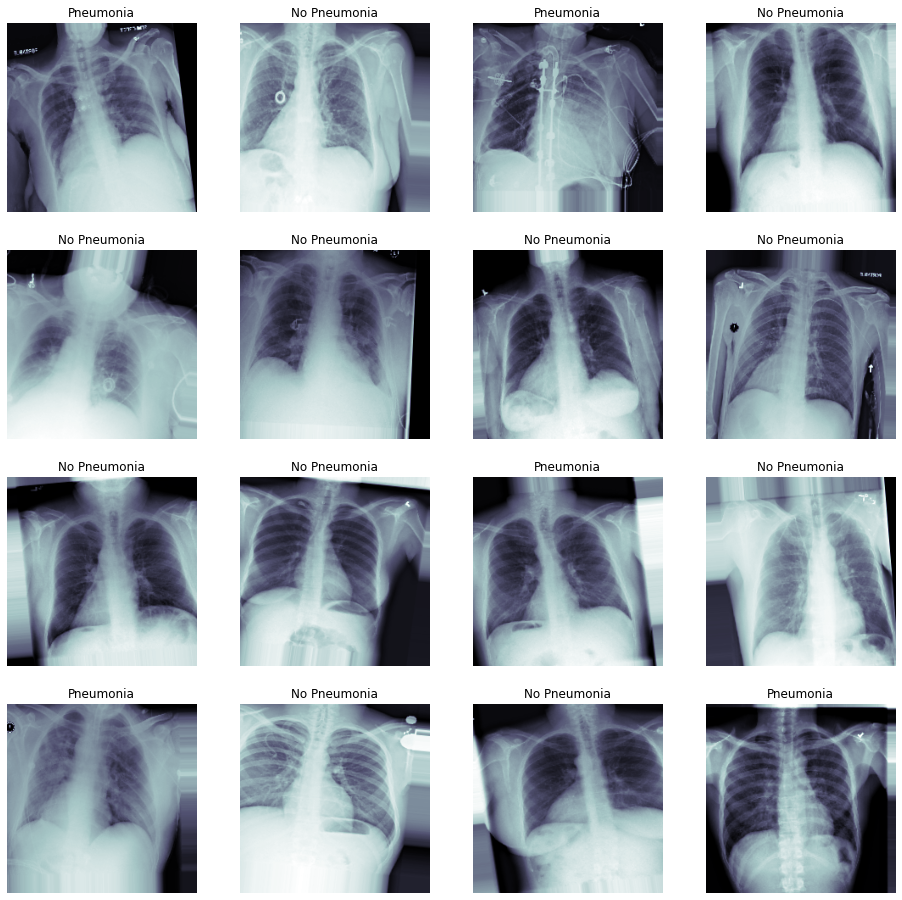

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
#     print(model.summary())
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [13]:
def build_my_model():
    
    # TODO:if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    vgg_model = load_pretrained_model()
    for layer in vgg_model.layers[0:16]:
        layer.trainable = False
        
    # TODO: add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.3))

#     # Add a dense (aka. fully-connected) layer.
#     # This is for combining features that the VGG16 model has
#     # recognized in the image.
#     my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,] 
    my_model.add(Dense(1, activation='sigmoid'))
        
    # TODO: also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
xray_model = build_my_model()
xray_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'binary_accuracy', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
## train your model

# Todo
history = xray_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 15, 
                          callbacks = callbacks_list)

Epoch 1/15
72/72 [==============================] - 72s 997ms/step - loss: 0.7463 - binary_accuracy: 0.5345 - val_loss: 0.6924 - val_binary_accuracy: 0.5234

Epoch 00001: binary_accuracy improved from -inf to 0.53450, saving model to xray_class_my_model.best.hdf5
Epoch 2/15
72/72 [==============================] - 62s 862ms/step - loss: 0.6871 - binary_accuracy: 0.5712 - val_loss: 0.6775 - val_binary_accuracy: 0.5938

Epoch 00002: binary_accuracy improved from 0.53450 to 0.57118, saving model to xray_class_my_model.best.hdf5
Epoch 3/15
72/72 [==============================] - 63s 868ms/step - loss: 0.6797 - binary_accuracy: 0.5694 - val_loss: 0.6641 - val_binary_accuracy: 0.6250

Epoch 00003: binary_accuracy did not improve from 0.57118
Epoch 4/15
72/72 [==============================] - 62s 864ms/step - loss: 0.6632 - binary_accuracy: 0.6105 - val_loss: 0.6703 - val_binary_accuracy: 0.6250

Epoch 00004: binary_accuracy improved from 0.57118 to 0.61048, saving model to xray_class_my_mo

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [17]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
xray_model.load_weights(weight_path)
pred_Y = xray_model.predict(valX, batch_size = 32, verbose = True)


128/128 [==============================] - 1s 10ms/step


In [18]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_graph(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

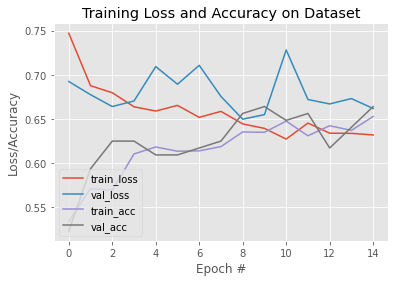

In [19]:
## plot figures

# Todo
plot_history(history)

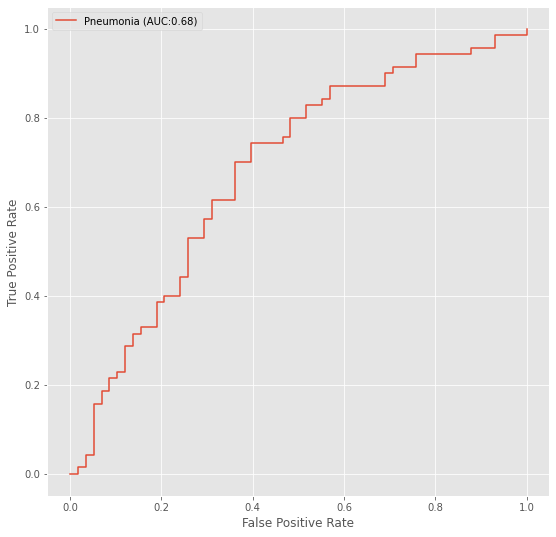

In [20]:
plot_auc(valY, pred_Y)

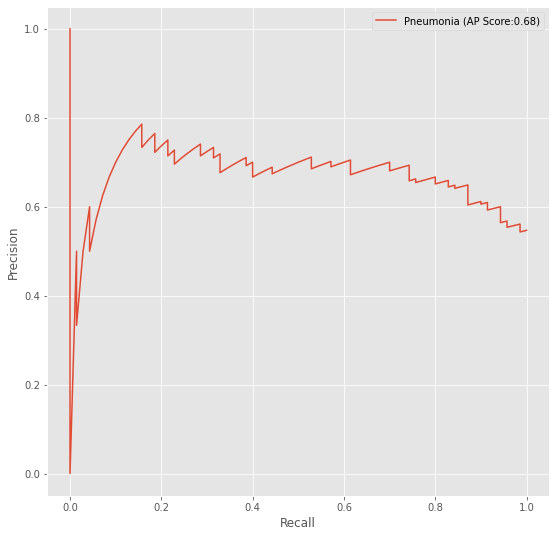

In [21]:
plot_precision_recall_graph(valY, pred_Y)

In [22]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
values = [i/10 for i in range(11)]

In [24]:
# Curve F1 score versus Threshold
# We need to find the F1 Score for all the thrsholds in the list
f1_score = []
precision_score = []
recall_score = []

valY = valY.astype(int)
for thresh in values:
    pred = []
    for prob in pred_Y:
        if prob > thresh:
            pred.append(1)
        else:
            pred.append(0)
    
    tn, fp, fn, tp = confusion_matrix(valY, pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    f1_score.append(f1)
    precision_score.append(precision)
    recall_score.append(recall)


Text(0, 0.5, 'F1 Score')

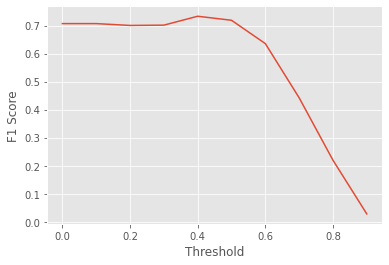

In [25]:
plt.plot(values,f1_score)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')   

Text(0, 0.5, 'Precision')

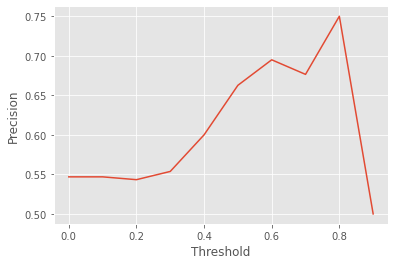

In [26]:
plt.plot(values,precision_score)
plt.xlabel('Threshold')
plt.ylabel('Precision')   

Text(0, 0.5, 'Recall')

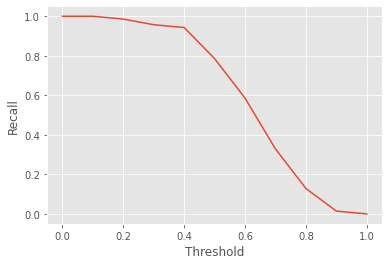

In [27]:
plt.plot(values,recall_score)
plt.xlabel('Threshold')
plt.ylabel('Recall') 

From the graph above, F1 score is close to 0.7 for thresholds ranging between 0 and 0.5 and then decreases sharply which leaves us even more confused for choosing one value for threshold. 

Therefore, we will peek into the graphs plotted for Precion and Recall based on the threshold. Since, the impact of detecting a false negative will be much more worse than detecting false positive. Hence, it is important to value recall more than precision to choose our threshold. Having that said, we also don't want a high number of false positive cases which can affect the credibility of the algorithm and can also lead to add more expenses to do further tests on patients.

A threshold between 0.4 - 0.5 will be a good balance to choose as it also weighs more on the Recall score and provides a reasonable Precision score. 

#### Going forward with the threshold value of 0.5

In [31]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

threshold = 0.5


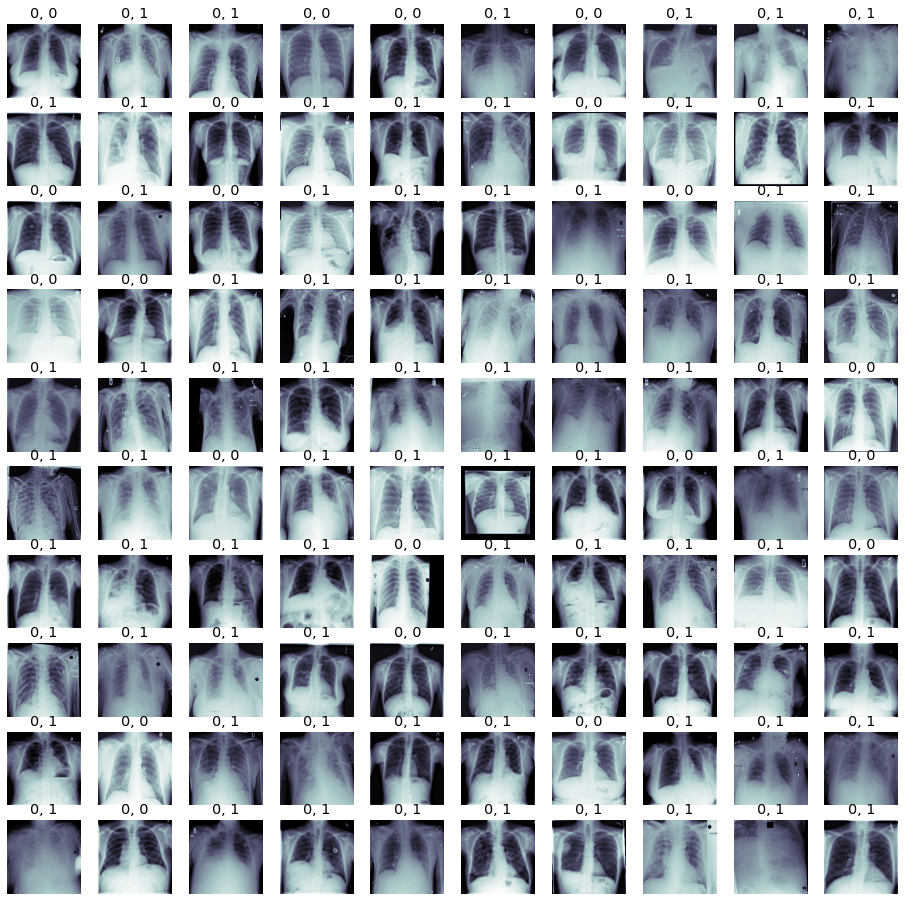

In [32]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
tp=0
fn=0
fp=0
tn=0
for (c_x, c_y, c_ax) in zip(valX[0:100], pred_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
            tp=tp+1
        else:
            c_ax.set_title('1, 0')
            fn=fn+1
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
            fp=fp+1
        else:
            c_ax.set_title('0, 0')
            tn=tn+1
    c_ax.axis('off')
    i=i+1

In [35]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)